# TP 1: Réseaux de neurones (1)

## 0. Introduction and préliminaires

Dans cette session, nous verrons des réseaux simples dense, dits "feed-forward" pour de la classification. 
Nous utiliserons le module Tensorflow et sa sous-partie Keras qui donne un accès de haut niveau aux éléments classiques d'une architecture de réseau de neurones.
On retrouvera matplotlib/pylab pour la visualisation. 


In [29]:
from __future__ import absolute_import, division, print_function, unicode_literals


import tensorflow as tf
from tensorflow import keras


import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)

2.11.0


## 1. Classifying handwritten digits (classification de chiffres manuscrits) 

Nous allons étudier le célèbre jeu de données MNIST, d'image de chiffres écrits à la main. 
Il contient 70000 instances de chiffres (0-9), dont 60000 réservés pour l'entrainement et 10000 pour le test. 

### Charger MNIST 
keras fournit une fonction spécialement dédiée:

In [30]:
(train_images, train_labels), (test_images, test_labels) = keras.datasets.mnist.load_data()

Les données sont chargées dans des matrices numpy

* `train_images` et `train_labels` contient les données d'entrainement
* `test_images` et `test_labels` contient les données de test, pour évaluer les performances du modèel

Les images sont des matrices de 28x28 pixels avec une valeur entre 0 et 255. 

Les labels sont les entiers représentant les chiffres correspondant à chaque image. 


### Exploration des données
Regardons un peu ce qu'il y a dans les données :

In [31]:
train_images.shape

(60000, 28, 28)

In [32]:
test_images.shape

(10000, 28, 28)

`train_images` est en fait un *tenseur*, un array numpy avec 3 axes, les 60000 instances de 28x28 valeurs, comme avoir un vecteur de matrices 28x28  


Par exemple, une image serait : 

In [33]:
train_images[0]

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,
         18,  18,  18, 126, 136, 175,  26, 166, 255, 247, 127,   0,   0,
          0,   0],
       [  

On voit que chaque pixel a une valeur entre 0 et 255. 

Pour chaque image, le vrai label est stocké avec le même indice dans `train_labels`

In [34]:
len(train_labels)

60000

Quel est le label de la première image ? 

In [35]:
print(train_labels[0])

5


### Prétraitements

Le code ci-dessous visualise la première image: 

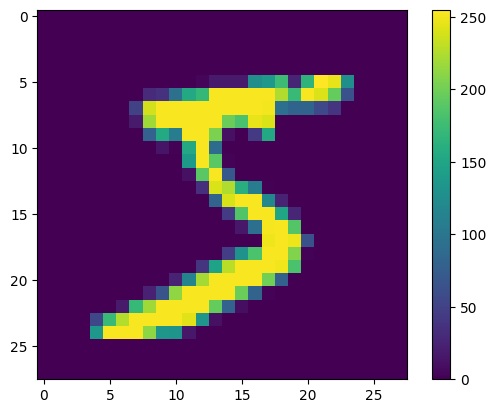

In [36]:
plt.figure()
plt.imshow(train_images[0])
plt.colorbar()
plt.grid(False)
plt.show()

Il est généralement préférable de normaliser les scores entre [0,1]

On peut juste ici se contenter de diviser par le max théorique (255)


In [37]:
train_images = train_images / 255.0

test_images = test_images / 255.0

On peut vérifier ce que ça donne sur quelques images

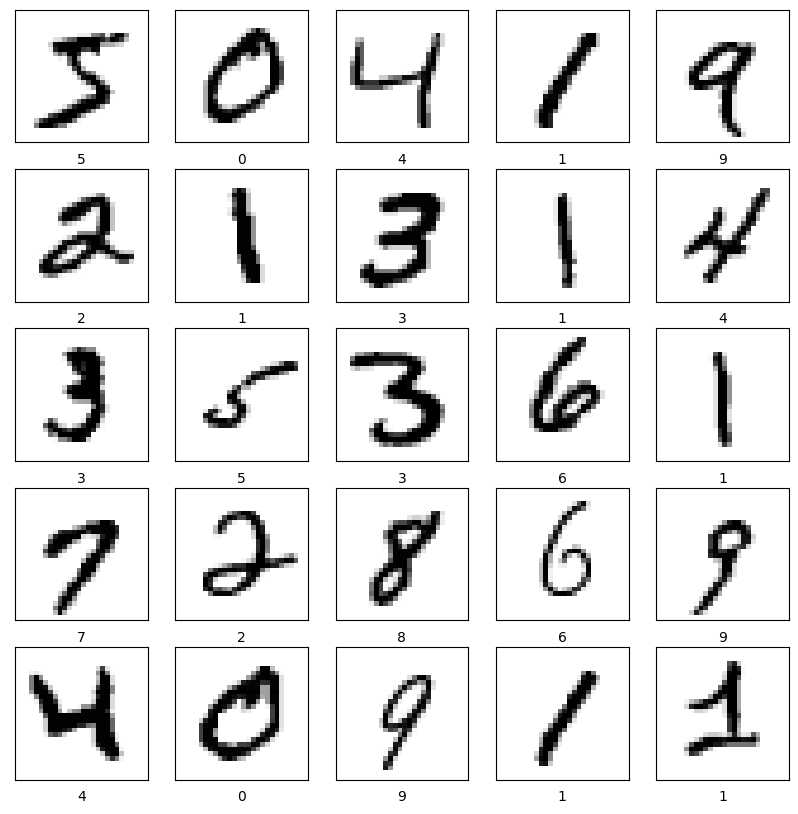

In [38]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(train_labels[i])
plt.show()

### Définir le modèle

Définir un modèle comporte plusieurs étapes. 

La première est d'articuler les couches qui constituent l'architecture.

Keras fournit une construction de séquence avec la classe `Sequential`, qui permet de combiner les éléments: couches, fonctions d'activation ... en "cachant" les paramètres qui seront appris. 

Par exemple: 

In [65]:
model = keras.Sequential([
    keras.layers.Dropout(0.5),
    keras.layers.Flatten(input_shape=(28, 28)),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(10, activation='softmax')
])

L'étape de traitement Flatten transforme la matrice 28x28 en un seul vecteur de (28 * 28 = 784) valeurs. 

Ensuite on ajoute des couches complètement connectées ("Dense"), qui relie l'entrée, 768 valeurs pour la première, 
et qui sort 2 résultats, qui sert d'entrée à la couche suivante (la dernière), qui sort 10 valeurs. 
On ajoute à chaque fois une fonction d'activation sur chaque sortie. 

Le softmax ramène les valeurs entre 0 et 1 en sortie, valant 1 au total, comme une distribution de probabilités. 

Ensuite on définit un certains nombre de points qui permettent de compléter pour pouvoir entrainer le modèle:  

* **une loss**: la fonction de perte; ici on a un problème de classification donc nous prendrons l'entropie croisée (cross-entropy)
* **un optimiseur**: la procedure pour minimiser la loss, on prendra le plus simple (sgd = stochastic gradient descent). 
* **une métrique**: qui sert à évaluer le modèle au final. Ici on veut savoir la proportion d'images correctement classifiées ("accuracy"). 


In [66]:
# Stochastic Gradient Descent
sgd = tf.keras.optimizers.SGD(learning_rate=0.05)

model.compile(optimizer=sgd,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'], )

### Entrainement 

Le modèle est compilé, et est prêt à être entrainé, en lui fournissant les données d'entrainement, avec la réponse attendue. 

La méthode pour entrainer le modèle s'appelle `fit`. 
Le modèle va voir chaque exemple plusieurs fois, à définir. On appelle "epoch" le fait d'avoir vu tous les exemples une fois. 
On spécifie donc le nombre d'epochs, ici 10, donc chaque exemple sera vu 10 fois.  

Un dernier paramètre est de dire combien d'exemples seront mis de côté pour surveiller les performances du modèle
au cours de l'entrainement (un jeu de validation, ou `validation split`).

Ici
`validation_split=0.1` dit à Keras de garder 10% du jeu de données pour validation.

Cela permet de surveiller par exemple l'overfitting. 

In [67]:
# Fonction pour l'affichage de l'historique des métriques d'apprentissage
def plot_history(history, val=False):
    plt.plot(history.history['accuracy'])
    if val:
        plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    if val:
        plt.legend(['train', 'val'], loc='upper left')
    else:
        plt.legend(['train'], loc='upper left')
    plt.show()

In [68]:
h = model.fit(train_images, train_labels, epochs=20, validation_split=0.1)

Epoch 1/20
1688/1688 [==============================] - 3s 2ms/step - loss: 0.5397 - accuracy: 0.8350 - val_loss: 0.2035 - val_accuracy: 0.9457
Epoch 2/20
1688/1688 [==============================] - 3s 2ms/step - loss: 0.3329 - accuracy: 0.8994 - val_loss: 0.1555 - val_accuracy: 0.9585
Epoch 3/20
1688/1688 [==============================] - 2s 1ms/step - loss: 0.2637 - accuracy: 0.9201 - val_loss: 0.1219 - val_accuracy: 0.9677
Epoch 4/20
1688/1688 [==============================] - 3s 2ms/step - loss: 0.2259 - accuracy: 0.9312 - val_loss: 0.1077 - val_accuracy: 0.9700
Epoch 5/20
1688/1688 [==============================] - 2s 1ms/step - loss: 0.2002 - accuracy: 0.9384 - val_loss: 0.0984 - val_accuracy: 0.9717
Epoch 6/20
1688/1688 [==============================] - 3s 1ms/step - loss: 0.1860 - accuracy: 0.9429 - val_loss: 0.0901 - val_accuracy: 0.9760
Epoch 7/20
1688/1688 [==============================] - 3s 1ms/step - loss: 0.1709 - accuracy: 0.9472 - val_loss: 0.0879 - val_accuracy:

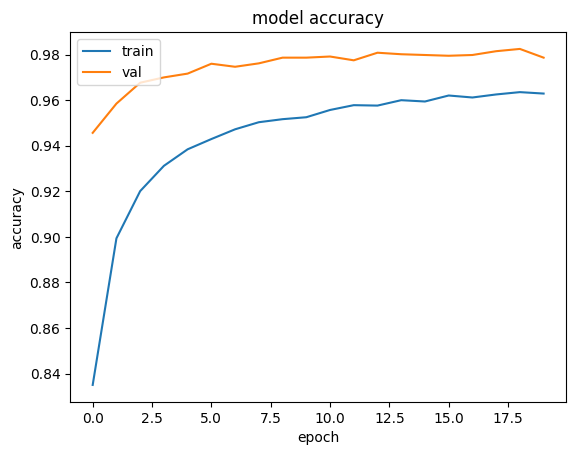

In [79]:
plot_history(h, val=True)

### Evaluation du modèle

Ensuite on vérifie la "vraie" performance une fois que l'entrainement est finie, sur les données de test. 

In [71]:
test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

print('\nTest accuracy:', test_acc)

313/313 - 0s - loss: 0.0715 - accuracy: 0.9761 - 353ms/epoch - 1ms/step

Test accuracy: 0.9761000275611877


### Faire des prédictions

On peut aussi utiliser le modèle pour faire des prédictions sur des images, ici voyons le résultat sur toutes les instances de test:

In [72]:
predictions = model.predict(test_images)

313/313 [==============================] - 0s 935us/step


Si on regarde les prédictions pour la première image du test : 

In [73]:
predictions[0]

array([1.9570066e-08, 3.4635931e-08, 3.8367084e-06, 3.4833942e-05,
       4.7277183e-08, 1.2828984e-07, 1.3807873e-11, 9.9995518e-01,
       8.2142620e-08, 5.8468795e-06], dtype=float32)

On voit la probabilité de chaque classe (donc d'être un numéro particulier). Pour trouver le meilleur on peut faire: 

In [74]:
np.argmax(predictions[0])

7

On peut vérifier que la réponse correspond au label attendu pour cet exemple : 

In [75]:
test_labels[0]

7

Voici une fonction pour afficher plus clairement le vecteur de probabilités : 

In [76]:
def plot_image(i, predictions_array, true_label, img, class_names=None):
    if class_names == None:
        class_names = range(len(predictions_array))
    predictions_array, true_label, img = predictions_array, true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    plt.imshow(img, cmap=plt.cm.binary)

    predicted_label = np.argmax(predictions_array)
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'

    plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
    predictions_array, true_label = predictions_array, true_label[i]
    plt.grid(False)
    plt.xticks(range(10))
    plt.yticks([])
    thisplot = plt.bar(range(10), predictions_array, color="#777777")
    plt.ylim([0, 1])
    predicted_label = np.argmax(predictions_array)

    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('blue')


On peut regarder sur la première image. En bleu la décision du modèle en rouge la bonne réponse. 

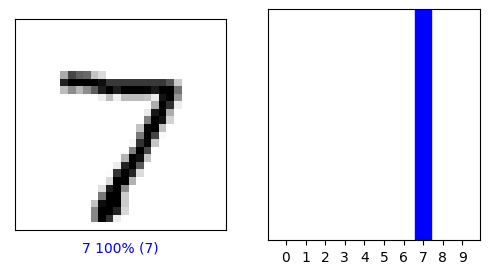

In [77]:
i = 0
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions[i], test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions[i],  test_labels)
plt.show()


La même chose pour 15 images. Pouvez vous voir si les erreurs sont cohérentes ? Si vous voyez pourquoi 

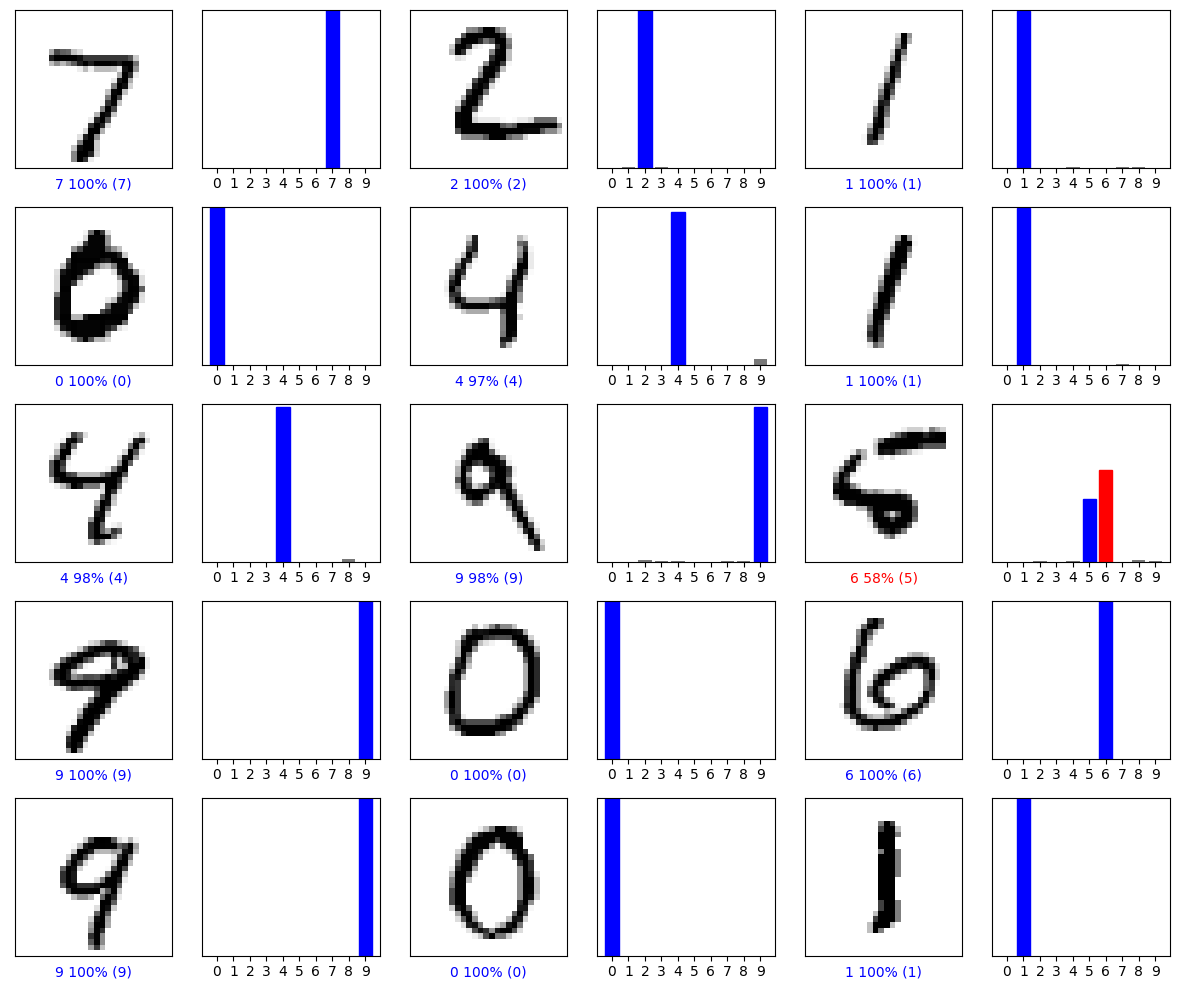

In [78]:
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions[i], test_labels, test_images)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions[i], test_labels)
plt.tight_layout()
plt.show()



### Exercices
* **Exercice 1**: Le modèle défini plus haut n'a qu'une couche cachée avec seulement deux neurones. Quelles sont les accuracies que vous obtenez sur le jeu d'entrainement ? sur le test ? Essayez d'augmenter le nombre de neurones pour voir l'influence de ce facteur. 

* **Exercice 2**: Il y a beaucoup de choix possibles pour la fonction d'activation. Regardez la documentation Keras (https://keras.io/api/layers/activations/) pour en essayer d'autres. Quelle est celle qui semble le mieux fonctionner ici ? 


* **Exercice 3**: On a vu en cours l'intérêt de régulariser le modèle, par exemple avec un "drop out", qui met au hasard à 0 un certain nombres de valeur pour éviter de trop spécialiser le modèle sur certains neurones.  Ajouter un drop out (https://keras.io/api/layers/regularization_layers/dropout/) à la première couche en donnant une probabilité de 0.5 (la moitié des neurones sont mis à 0 après un passage). 

* **Exercice 4**: Faites varier la procédure d'optimisation de la loss, en testant certaines possibilités de Keras (https://keras.io/api/optimizers/#available-optimizers). Qu'est-ce qui marche le mieux ? 


* **Exercise 5**: Essayez de changer le modèle en ajoutant une ou plusieurs couches. 


* **Exercise 6; bonus**: Dessinez votre propre chiffre, et utilisez votre modèle pour faire une prédiction. Il faut que l'image soit de la taille 28x28. Vous pouvez utiliser par exemeple https://www.pixilart.com/draw. 
Pour charger l'image utilisez la fonction `plt.imread`. L'image produite eest en RGBA, et donc l'array retourné de dimensions (28,28,4) matrix. Vous pouvez juste prendre le canal rouge avec les indices `[:,:,0]` et ensuite faire `image = np.expand_dims(image, axis=0)` pour passer l'image (28,28) en (1,28,28) qui est ce qu'attend la fonction `model.predict` (un vecteur d'image 28x28, ici de taille 1).

In [25]:
## Exercise 6: 
## à vous de jouer

## 2. Reconnaissance d’objets

### Les données CIFAR10 

Le jeu de données cifar10 contient 60000 instances d'images représentant 10 classes d'objets, avec leur label. Keras permet de le charger directement : 

In [80]:
(train_images, train_labels), (test_images, test_labels) = keras.datasets.cifar10.load_data()

170498071/170498071 [==============================] - 19s 0us/step


Les labels sont codés un peu différemment. Pour avoir un seul vecteur de labels, on va d'abord aplatir les vecteurs donnés. 

In [81]:
train_labels = train_labels.flatten()
test_labels = test_labels.flatten()

In [82]:
train_images[0].shape

(32, 32, 3)

Chaque classe est représentée par un nombre, on va donc leur associer un nom. 

In [83]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

Voilà comment afficher les premières images de la base: 

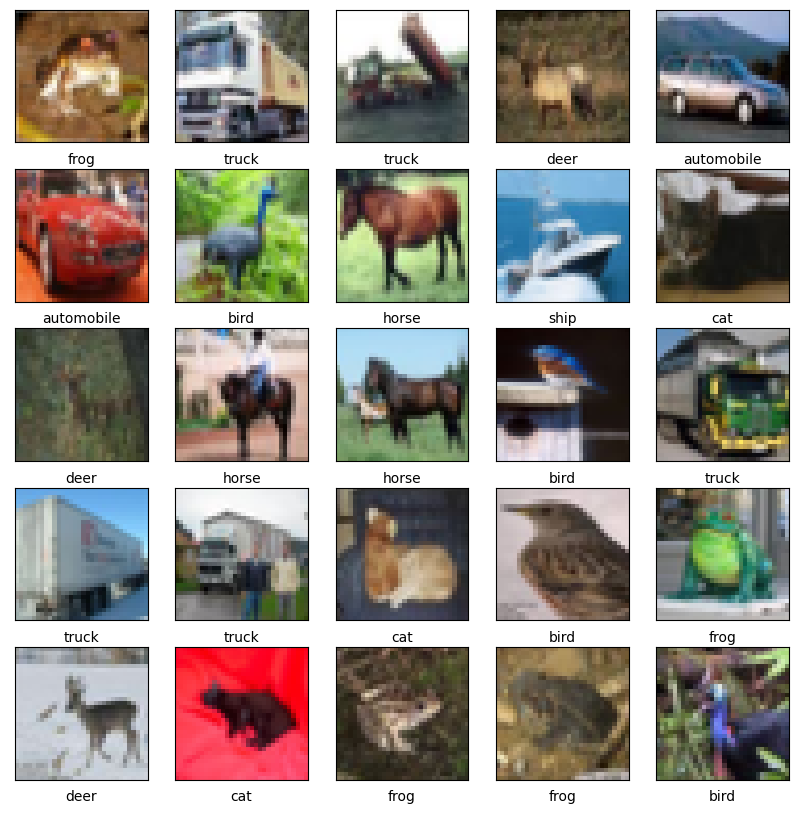

In [84]:
train_labels = train_labels.flatten()
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i]])
plt.show()

### Exercices

* **Exercice 7**: Définissez une architecture de reconnaissance d'objets pour CIFAR en vous inspirant de ce que vous avez fait pour MNIST, toujours `Sequential`. Compilez le modèle avec une loss, un optimiseur et une métrique. Faites variez les paramètres pour obtenir le meilleur résultat que vous pouvez. Vous pouvez encore utiliser `plot_image` et `plot_value_array` définies plus haut pour explorer les prédictions du modèle sur une seule image. 

In [113]:
## Exercice 7

## à vous ... 
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(32, 32, 3)),
    #keras.layers.Dropout(0.5),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.Dense(512, activation='sigmoid'),
    keras.layers.Dense(10, activation='softmax')
])

In [114]:
sgd = tf.keras.optimizers.SGD(learning_rate=0.05)

model.compile(optimizer=sgd,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'], )

In [115]:
h = model.fit(train_images, train_labels, epochs=20, validation_split=0.1)

Epoch 1/20
1407/1407 [==============================] - 9s 6ms/step - loss: 2.6620 - accuracy: 0.1007 - val_loss: 2.7870 - val_accuracy: 0.1038
Epoch 2/20
1407/1407 [==============================] - 8s 6ms/step - loss: 2.6206 - accuracy: 0.1005 - val_loss: 2.4640 - val_accuracy: 0.1066
Epoch 3/20
1407/1407 [==============================] - 8s 6ms/step - loss: 2.6303 - accuracy: 0.0985 - val_loss: 3.4380 - val_accuracy: 0.0976
Epoch 4/20
1407/1407 [==============================] - 9s 6ms/step - loss: 2.6383 - accuracy: 0.1020 - val_loss: 3.7942 - val_accuracy: 0.0976
Epoch 5/20
1407/1407 [==============================] - 9s 6ms/step - loss: 2.6459 - accuracy: 0.1004 - val_loss: 3.0538 - val_accuracy: 0.0986
Epoch 6/20
1407/1407 [==============================] - 9s 6ms/step - loss: 2.6360 - accuracy: 0.0991 - val_loss: 5.2625 - val_accuracy: 0.1064
Epoch 7/20
1407/1407 [==============================] - 9s 6ms/step - loss: 2.6455 - accuracy: 0.0999 - val_loss: 2.9958 - val_accuracy:

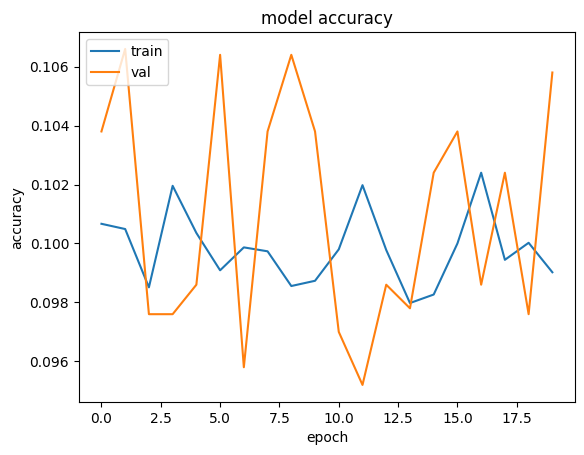

In [116]:
plot_history(h, val=True)

In [117]:
test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

print('\nTest accuracy:', test_acc)

313/313 - 1s - loss: 2.9659 - accuracy: 0.1000 - 930ms/epoch - 3ms/step

Test accuracy: 0.10000000149011612


313/313 [==============================] - 1s 3ms/step


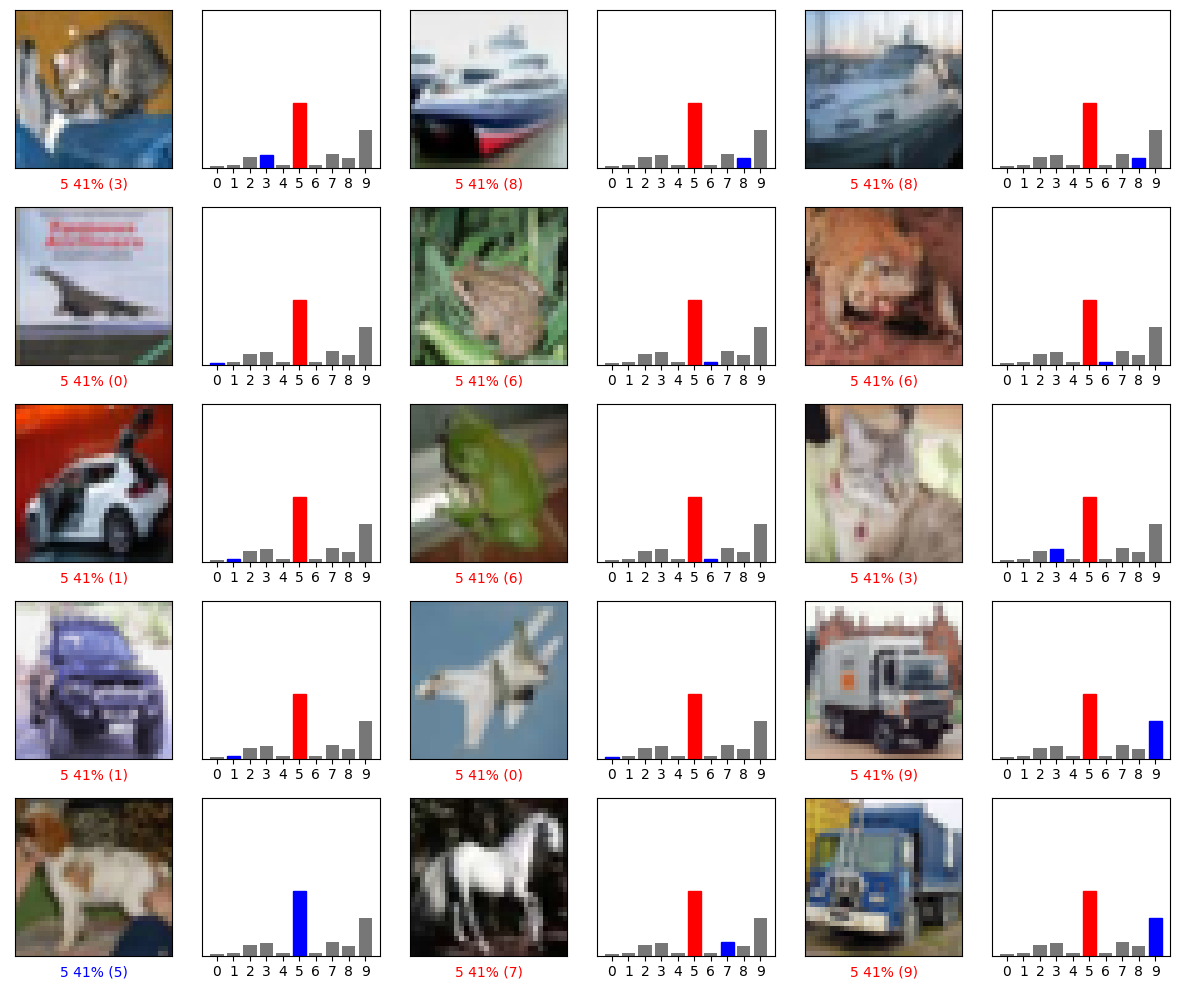

In [118]:
predictions = model.predict(test_images)

num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions[i], test_labels, test_images)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions[i], test_labels)
plt.tight_layout()
plt.show()
